# 1.将VGG16卷积基实例化

In [1]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

conv_base.summary()

58892288/58889256 [==============================] - 127s 2us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_po

# 2.不使用数据增强的快速特征提取

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r'/data/dataset/dogs_cats/cats_dogs_small_dataset/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1.0/255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size:(i+1)*batch_size] = features_batch
        labels[i * batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
# 需要展平后才能输入到密集链接分类器中
train_features = np.reshape(train_features, (2000, -1))
validation_features = np.reshape(validation_features, (1000, -1))
test_features = np.reshape(test_features, (1000, -1))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 3.定义并训练密集连接分类器

In [5]:
from keras import models 
from keras import layers 
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

print()
history.history.keys()

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 353us/step - loss: 0.6009 - acc: 0.6665 - val_loss: 0.4308 - val_acc: 0.8220
Epoch 2/30
2000/2000 [==============================] - 0s 164us/step - loss: 0.4269 - acc: 0.8095 - val_loss: 0.3567 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 0s 157us/step - loss: 0.3554 - acc: 0.8380 - val_loss: 0.3223 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 0s 170us/step - loss: 0.3076 - acc: 0.8770 - val_loss: 0.2996 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 0s 164us/step - loss: 0.2848 - acc: 0.8815 - val_loss: 0.2850 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 0s 156us/step - loss: 0.2568 - acc: 0.8955 - val_loss: 0.2849 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 0s 160us/step - loss: 0.2409 - acc: 0.9065 - val_loss: 0.2635 - val_acc: 0.9030


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# 4.绘制结果

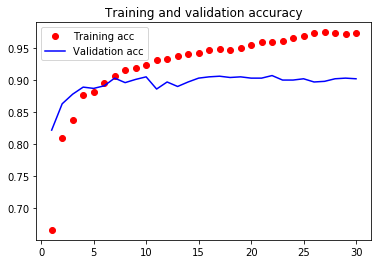

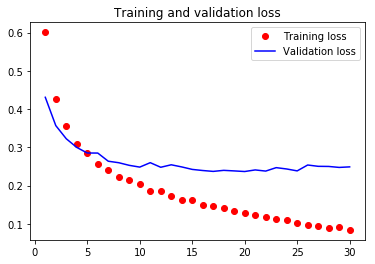

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
我们的验证精度达到了约 90%，比上一节从头开始训练的小型模型效果要好得多。但从图
中也可以看出，虽然 dropout 比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有
使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

# 5.使用数据增强的特征提取

In [18]:
from keras import regularizers
# 在卷积基上添加一个密集连接分类器
net = models.Sequential()
net.add(conv_base)
net.add(layers.Flatten())
net.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
net.add(layers.Dense(1, activation='sigmoid'))

net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
# 在编译和训练模型之前,一定要"冻结"卷积基.
print('This is the number of trainable weghts before freezing the conv base', len(net.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weghts after freezing the conv base', len(net.trainable_weights))

This is the number of trainable weghts before freezing the conv base 30
This is the number of trainable weghts after freezing the conv base 4


# 6.利用冻结的卷积基端到端地训练模型

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# 注意不能增强验证集数据
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20, 
    class_mode='binary'
)

net.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = net.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_generator,
    validation_steps=50
)

print()
history.history.keys()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6358 - acc: 0.6940 - val_loss: 0.4882 - val_acc: 0.8370
Epoch 2/30
100/100 [==============================] - 11s 106ms/step - loss: 0.5190 - acc: 0.7955 - val_loss: 0.4200 - val_acc: 0.8500
Epoch 3/30
100/100 [==============================] - 11s 110ms/step - loss: 0.4762 - acc: 0.8065 - val_loss: 0.3709 - val_acc: 0.8780
Epoch 4/30
100/100 [==============================] - 11s 109ms/step - loss: 0.4440 - acc: 0.8280 - val_loss: 0.3476 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 11s 107ms/step - loss: 0.4202 - acc: 0.8370 - val_loss: 0.3331 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 11s 107ms/step - loss: 0.4019 - acc: 0.8375 - val_loss: 0.3401 - val_acc: 0.8770
Epoch 7/30
100/100 [==============================] - 11s 108ms/step - loss: 0.4079 - acc: 0.8375 - val_lo

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

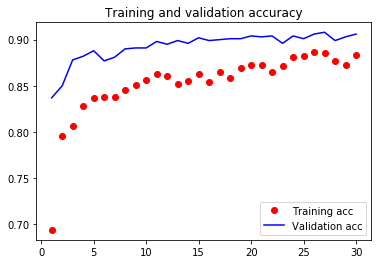

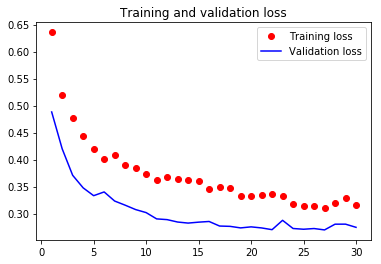

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
conv_base.trainable = True
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [23]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

In [24]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# 7.微调模型

Epoch 1/30
100/100 [==============================] - 12s 118ms/step - loss: 0.3270 - acc: 0.8720 - val_loss: 0.2584 - val_acc: 0.9160
Epoch 2/30
100/100 [==============================] - 11s 109ms/step - loss: 0.2838 - acc: 0.8960 - val_loss: 0.2354 - val_acc: 0.9200
Epoch 3/30
100/100 [==============================] - 11s 108ms/step - loss: 0.2664 - acc: 0.8965 - val_loss: 0.2645 - val_acc: 0.9100
Epoch 4/30
100/100 [==============================] - 11s 110ms/step - loss: 0.2365 - acc: 0.9150 - val_loss: 0.2749 - val_acc: 0.9080
Epoch 5/30
100/100 [==============================] - 11s 109ms/step - loss: 0.2509 - acc: 0.9065 - val_loss: 0.2419 - val_acc: 0.9240
Epoch 6/30
100/100 [==============================] - 11s 107ms/step - loss: 0.2400 - acc: 0.9095 - val_loss: 0.2212 - val_acc: 0.9290
Epoch 7/30
100/100 [==============================] - 11s 108ms/step - loss: 0.2231 - acc: 0.9210 - val_loss: 0.2490 - val_acc: 0.9210
Epoch 8/30
100/100 [==============================] - 1

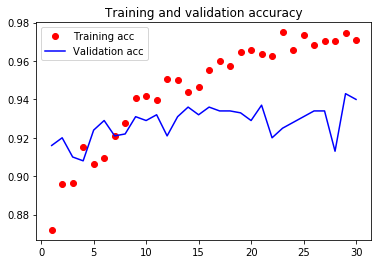

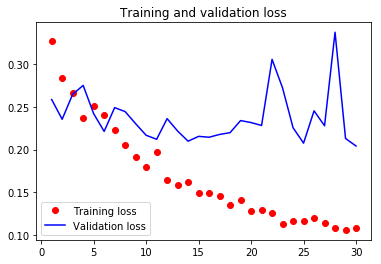

In [26]:
net.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc']
)

history = net.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_generator,
    validation_steps=50
)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 8.使曲线变得平滑

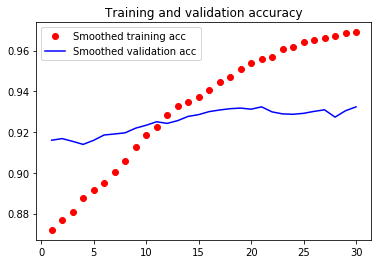

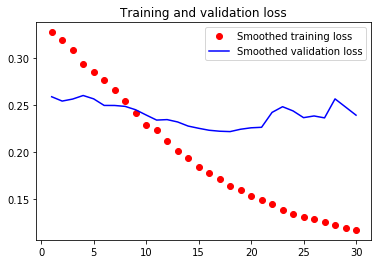

In [32]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs,
smooth_curve(acc), 'ro', label='Smoothed training acc')

plt.plot(epochs,
smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
smooth_curve(loss), 'ro', label='Smoothed training loss')
plt.plot(epochs,
smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
test_generator = val_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

test_loss, test_acc = net.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9409999895095825
